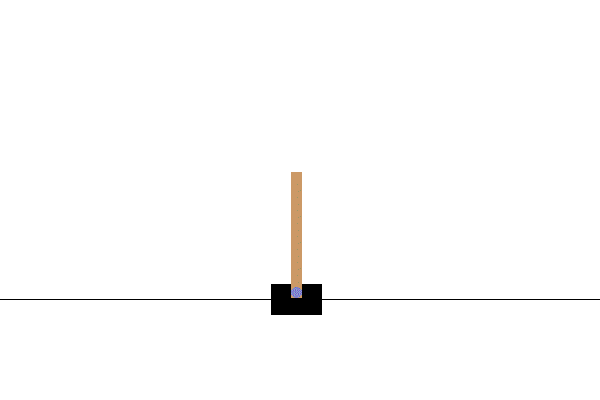

# Our goal is to help the platform balance this stick without its position going too off center and without the angle of the pole being too far from veritcal


# We start of with a random position,speed,pole angle and pole speed and we can interact with the environment by applying force 0 (left) or 1 (right)

# Each unit of time that passes (I have no idea what the unit is exactly (ms maybe?)) we get a reward of 1. So we aim to keep the pole upright for as long as possible, to get maximum reward.


# I wil now attempt to explain enough so that you can appriciate how cool this thing is

# the 4 numbers we get (position,velocity,pole_angle,pole_velocity) are the state. We want a policy π that we can input a state and it outputs 0 or 1, (left or right). e.g. π(0.1,0.2,-0.1,0.3) = 0 

# Given some fixed policy π we can define a action-value function Q_π(state,action) -> (expected cumulative return until the end of the episode if at (state) we use (action) and then we follow policy π)

# Now if π was the best possible policy if we took action at state_1 and we then went to state_2 and got reward r then Q_π(state,action) = r + max_(over all actions of state_2)(Q_π(state_2,action))

# This is called the TD target (if you want to google it)

# In finite state spaces if we initialize the Q function randomly and then iterate many times setting Q_π(state,action) = r + max_(over all actions of state_2)(Q(state_2,action)) it turns out Q_π(state,action) will in fact output the value of the optimal policy, and hence we can derive the optimal policy by simply choosing the action with the most cumlative expected reward 

# This is cool but what is cooler is that we now give up on the assumptions of finite state spaces and a lot of other assumptions that guarantee convergence to the optimal policy, and we now put a neural net to approximate the Q function. In fact our net is such that Net(state) -> action. We will then sample observed state,action,state sequences that occured when we were playing the game, and treat this as a supervised learning problem, trying to get the prediction (Q_π(state,action)) to match (r + max_(over all actions of state_2)(Q_π(state_2,action))). Note that our target is also a prediction, but we hope that the fact that r is an actual observed reward injects some information about the reality of the situation and hopefully get a neural net which is actually the Q function of the optimal policy. Then we can just find the optimal action by checking which action our neural net likes best!

# 2 things that we do to help the neural network converge better, is we sample our observed state,action,state sequences from a special memory that holds all sequences (transitions) we have seen so far, to ensure our samples are as IID as possible. (neural nets like IID) . Also instead of using our own network to produce the td targets we use a lagged version of it, in order to make the targets more stable (which is also good for neural nets)

# there is also the exploration epsilon and gamma which i have not mentioned which account for how often our agent does random moves to explore rather than the optimal policy and how much less our agent values rewards after some time steps. But don't worry about those, I would be very happy if you could just follow the notebook and identify the important parts I mentioned above.

# At the beggining we install some things that were missing from the kaggle coding environment in order for the gymnasium library (which simulates the pole environment) to work properly

In [12]:
!apt-get update

Hit:1 http://security.ubuntu.com/ubuntu focal-security InRelease
Hit:2 http://archive.ubuntu.com/ubuntu focal InRelease
Hit:3 http://archive.ubuntu.com/ubuntu focal-updates InRelease
Hit:4 http://archive.ubuntu.com/ubuntu focal-backports InRelease
Hit:5 https://packages.cloud.google.com/apt gcsfuse-focal InRelease
Hit:6 https://packages.cloud.google.com/apt cloud-sdk InRelease
Reading package lists... Done


In [13]:
!apt-get install -y swig

Reading package lists... Done
Building dependency tree       
Reading state information... Done
swig is already the newest version (4.0.1-5build1).
0 upgraded, 0 newly installed, 0 to remove and 30 not upgraded.


In [14]:
!pip install gymnasium[box2d]

# importing gymnasium
https://gymnasium.farama.org/

in particular we are using the cartpole envoronment that can be found here:

https://www.gymlibrary.dev/environments/classic_control/cart_pole/

In [15]:
import gymnasium as gym

env = gym.make('CartPole-v1')

# Here we implement the neural network, he define a class which lets us quickly create any fully connected network

In [16]:
import torch
from torch import nn
import torch.nn.functional as F

class DQN(nn.Module):
    def __init__(self,input_dim,output_dim,hidden_dims = (32,32),activation = F.relu):
        super().__init__()
        self.activation_f = activation
        self.fc_input = nn.Linear(input_dim,hidden_dims[0])

        self.module_list = nn.ModuleList()

        for i in range(len(hidden_dims)-1):
            layer = nn.Linear(hidden_dims[i],hidden_dims[i+1])
            self.module_list.append(layer)

        self.fc_output = nn.Linear(hidden_dims[-1],output_dim)

    def forward(self,X):
        f = self.activation_f
        out = f(self.fc_input(X))

        for module in self.module_list:
            out = f(module(out))

        out = f(self.fc_output(out))

        return out



# The architecture for the DQN agent is covered in chapters 8 and 9 of the grokking deep learning book (which i have attempted to explain in the prologue)
https://www.manning.com/books/grokking-deep-reinforcement-learning

# First we create a class for the memory buffer, which helps us sample past expirience tuples. By sampling randomly from a large sample of past expiriences we make each sample as IID with respect to each other as possible

In [17]:
from collections import deque
import numpy as np

#our memory class. It has an append method and a sample method which returns (batch_size) random samples. We implement the container as deque
class replay_memory():
    def __init__(self,capacity):
        self.memory = deque(maxlen = capacity)

    def __len__(self):
        return len(self.memory)

    def append(self,item):
        self.memory.append(item)

    def sample(self,batch_size):
        return random.sample(self.memory,batch_size)

# The DQN agent utililizes a replay buffer to make samples more IID and a target network to make targets more stable. It treats this reinforcement learning problems as supervised learning using the TD targets i mentioned above

In [18]:
from torch.optim import Adam
import torch.nn.functional as F
import random

#the class of the agent, which will hold 2 neural networks, the target network and the policy network
class DQNAgent():
    def __init__(self,state_space_n,action_space_n):
        self.state_space_n = state_space_n
        self.action_space_n = action_space_n
        self.memory = replay_memory(100000)
        self.batch_size = 64
        self.gamma = 0.99
        self.epsilon = 1
        self.min_epsilon = 0.01
        self.epsilon_decay = 0.995
        self.lr = 0.001
        #the 2 neural networks as promised they are instantiated as fully connected (4,512,128,64,2). 
        #Feel free to change it up and rerun the notebook to see what happens
        self.policy_net = DQN(self.state_space_n,self.action_space_n,hidden_dims = (512,128,64))
        self.target_net = DQN(self.state_space_n,self.action_space_n,hidden_dims = (512,128,64))

        self.optimizer = Adam(self.policy_net.parameters(),lr = self.lr)

        self.update_target_network()
    #updating the target network which is the one we use to create the TD targets to match the policy one
    def update_target_network(self):
        self.target_net.load_state_dict(self.policy_net.state_dict())
    #selecting action with an epsilon greedy policy (epsilon decays slowly from 1 to 0.01 in the optimize method)
    def select_action(self,state):
        if np.random.random() < self.epsilon:
            return random.randrange(self.action_space_n)
        else:
            with torch.no_grad():
                state = torch.tensor(state)
                return self.policy_net(state).argmax().item()
    #another select action method that chooses the best move every time
    def select_best_action(self,state):
        with torch.no_grad():
            state = torch.tensor(state)
            return self.policy_net(state).argmax().item()
        
    #we run this to sample a batch of transitions from memory create TD targets using target network and optimize the policy network with them
    def optimize_model(self):
        if len(self.memory)<self.batch_size: #if we have less samples in memory than batch size do nothing
            return
        else:
            #here we take out the (state,action,reward,next_state,done) tuple and use it to create targets
            transitions = self.memory.sample(self.batch_size)
            batch = list(zip(*transitions))

            states = torch.tensor(batch[0])
            actions = torch.tensor(batch[1],dtype = torch.long).unsqueeze(1)
            rewards = torch.tensor(batch[2])
            next_states = torch.tensor(batch[3])
            dones = torch.tensor(batch[4],dtype = torch.float)

            target_qvalues = self.gamma * self.target_net(next_states).max(1)[0].detach()*(1-dones) + rewards #these are the TD targets
            current_qvalues = self.policy_net(states).gather(1,actions)

            loss = F.mse_loss(current_qvalues.squeeze(),target_qvalues)
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

            if self.epsilon > self.min_epsilon:
                self.epsilon *= self.epsilon_decay




# Here we take the agent for a spin. A few things to note:
# 1) Gymnasium truncates the cartpole environment such that 500 is the maximum score
# 2) A score of 10-20 is about as good as one can achieve randomly

In [19]:
env = gym.make('CartPole-v1')
episodes = 1000
target_update = 10
agent = DQNAgent(4,2)

reward_tracker = np.zeros(episodes)
for episode in range(episodes):

    episode_reward = 0
    state,info = env.reset()
    done,truncated = False,False

    while not (done or truncated):

        action = agent.select_action(state)
        next_state, reward, done, truncated, info = env.step(action)
        episode_reward += reward
        agent.memory.append((state,action,reward,next_state,done))
        state = next_state

    agent.optimize_model()
    reward_tracker[episode] = episode_reward
    if episode % target_update == 0:
        agent.update_target_network()
        print(f'In episode -{episode}- agent earned reward -{episode_reward}-')






In episode -0- agent earned reward -13.0-
In episode -10- agent earned reward -12.0-
In episode -20- agent earned reward -14.0-
In episode -30- agent earned reward -22.0-
In episode -40- agent earned reward -36.0-
In episode -50- agent earned reward -18.0-
In episode -60- agent earned reward -10.0-
In episode -70- agent earned reward -13.0-
In episode -80- agent earned reward -33.0-
In episode -90- agent earned reward -24.0-
In episode -100- agent earned reward -12.0-
In episode -110- agent earned reward -16.0-
In episode -120- agent earned reward -21.0-
In episode -130- agent earned reward -23.0-
In episode -140- agent earned reward -43.0-
In episode -150- agent earned reward -46.0-
In episode -160- agent earned reward -25.0-
In episode -170- agent earned reward -35.0-
In episode -180- agent earned reward -97.0-
In episode -190- agent earned reward -38.0-
In episode -200- agent earned reward -15.0-
In episode -210- agent earned reward -44.0-
In episode -220- agent earned reward -97.0-

# We plot the score over the 1000 episodes. Note how much variance there is in the score

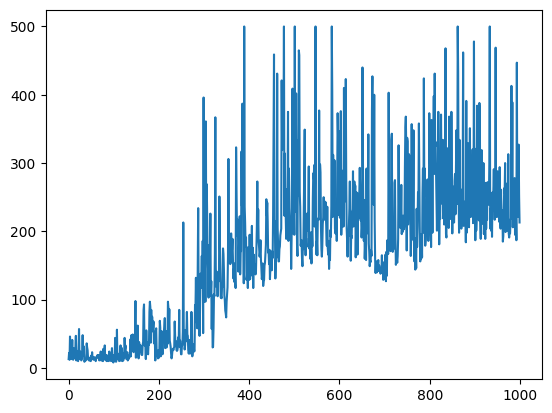

In [20]:
import matplotlib.pyplot as plt
plt.plot(np.arange(0,episodes),reward_tracker)


# Here we play it again but we dont let the agent to any exploration, he just uses the optimal strategy.
# Our exploration epsilon was 0.01 at the end of the episodes so it doesn't really matter. 

In [21]:
episodes = 50
reward_tracker = np.zeros(episodes)

for episode in range(episodes):

    episode_reward = 0
    done,truncated = False,False
    state,info = env.reset()

    while not (done or truncated):
        action = agent.select_best_action(state)
        next_state,reward,done,truncated,info = env.step(action)
        episode_reward += reward
        state = next_state

    reward_tracker[episode] = episode_reward
print('done')



done


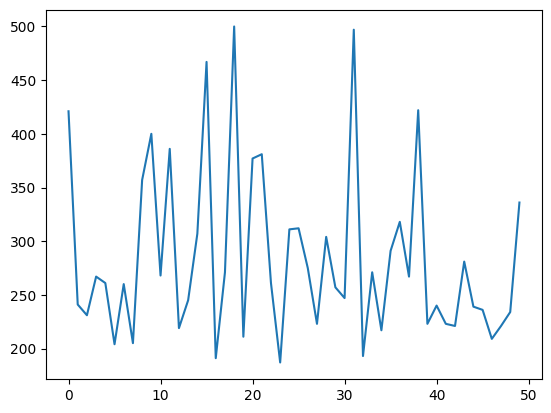

In [22]:
plt.plot(np.arange(0,episodes),reward_tracker)

# There is slightly better consistency here, however i am not convinced this isn't just luck

# Thanks for reading through my simple implementation of DQN. If you want a thorough (practical) understanding of both pytorch and deep reinforcment learning I would say the shortest path to get there is:

https://www.manning.com/books/deep-learning-with-pytorch (chapters 1-8)

and then 

https://www.manning.com/books/grokking-deep-reinforcement-learning 